#Overview & motivation

All of our team members enjoy movies. In addition to enjoying movies, we also enjoy working with API’s and somewhat structured data sets. Therefore, determining what makes a movie successful using the data available in the Internet Movie Database (IMDB) seemed like a natural choice.

In [56]:
from imdb import IMDb
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import cPickle as pickle
ia = IMDb(accessSystem='http')
from collections import defaultdict 
import io
from datetime import datetime
import time
import math
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

#Initial Questions



Given that a movie is nominated for an Oscar, can we build a classifier that predicts winners?  What are the 

#Data

###Import Data

Because the goal of this aspect of our project is to attempt to predict Oscar winners from those nominated, we first we split our data into a test set (movies in 2006) and a training set (movies 1981-2005).  We will use k-fold cross validation to train our model.  In this preliminary analysis, we train our model to predict Oscar winners given the movie was nominated.

We create a data frame to use for building our classifier, deleting columns not realted to the analysis.  The remaining columns are predictors can effectively choose the winners.  

In [81]:
# Load AAdictfinal (dict of Oscar nominated movies) and convert to DataFrame
AAdf = pd.DataFrame.from_dict(pickle.load(open('AAdictfinal','rb'))).transpose()

In [82]:
dftouse = AAdf.copy()
dftouse.reset_index(level=0, inplace=True)

In [83]:
cols_to_delete = [ u'Won Best Actor',
 u'Won Best Actress',
 u'Won Best Animated Feature Film',
 u'Won Best Art Direction',
 u'Won Best Cinematography',
 u'Won Best Costume Design',
 u'Won Best Director',
 u'Won Best Documentary, Feature',
 u'Won Best Documentary, Short Subject',
 u'Won Best Film Editing',
 u'Won Best Foreign Language Film',
 u'Won Best Makeup',
 u'Won Best Music, Adaptation / Original Song Score',
 u'Won Best Music, Dramatic Score',
 u'Won Best Music, Musical or Comedy Score',
 u'Won Best Music, Original Score',
 u'Won Best Music, Song',
 u'Won Best Picture',
 u'Won Best Short Film, Animated',
 u'Won Best Short Film, Live Action',
 u'Won Best Sound',
 u'Won Best Sound Editing',
 u'Won Best Sound Effects Editing',
 u'Won Best Sound Mixing',
 u'Won Best Supporting Actor',
 u'Won Best Supporting Actress',
 u'Won Best Visual Effects',
 u'Won Best Writing, Adapted Screenplay',
 u'Won Best Writing, Original Screenplay',
 u'Won Special Achievement Award',
 u'mpaa',
 u'title',
 u'movieid',
 u'cast',
 u'director',
 u'genres',
 u'countrylist',
 u'keywords',
 u'releasedate',
 u'country',
 u'won',
 u'nominations',
 u'index']
for col in cols_to_delete:
    del dftouse[col]

In [84]:
print list(dftouse.columns)

[u'Action', u'Adventure', u'Animation', u'Biography', u'Comedy', u'Crime', u'Documentary', u'Drama', u'Family', u'Fantasy', u'France', u'Germany', u'History', u'Horror', u'Italy', u'Music', u'Musical', u'Mystery', u'News', u'Nominated Best Actor', u'Nominated Best Actress', u'Nominated Best Animated Feature Film', u'Nominated Best Art Direction', u'Nominated Best Cinematography', u'Nominated Best Costume Design', u'Nominated Best Director', u'Nominated Best Documentary, Feature', u'Nominated Best Documentary, Short Subject', u'Nominated Best Film Editing', u'Nominated Best Foreign Language Film', u'Nominated Best Makeup', u'Nominated Best Music, Adaptation / Original Song Score', u'Nominated Best Music, Dramatic Score', u'Nominated Best Music, Musical or Comedy Score', u'Nominated Best Music, Original Score', u'Nominated Best Music, Song', u'Nominated Best Picture', u'Nominated Best Short Film, Animated', u'Nominated Best Short Film, Live Action', u'Nominated Best Sound', u'Nominated B

Now we create a list of the continuous variables in NONINDICATORS and a list of binary variables in INDICATORS.  This will allow us to do exploratory data analysis.  

We also needed to recode the "Nominated XX" columns. When the dataframe was constructed, the categories were coded as 0 if not nominated and name of the nominee if nominated.  We instead converted all "Nominated XX" columns to be 0 if not nominated and 1 if nominated.

In [85]:
# Creat a list of indicator variables
NONINDICATORS = set(['month','mpaaint','numnominations','quarter','runtime'])
INDICATORS = set(list(dftouse.columns)) - set(NONINDICATORS)
INDICATORS.remove(u'winner')
INDICATORS.remove('year')

In [86]:
for indicatorcol in INDICATORS:
    # Change strings to booleans
    if u'Nominated' in indicatorcol:
        dftouse[indicatorcol] = dftouse[indicatorcol].apply(lambda x: (type(x)==unicode or type(x)==str or x == True)*1)

##Exploratory Data Analysis


### Relationship between Non-Binary Variables and Outcome

First we look at continuous variables.  Grouping by winners and losers, we should be able to see if any of the continous variables will be good predictors for Oscar winners.  A good predictor will not have overlapping distributions for winners and losers.

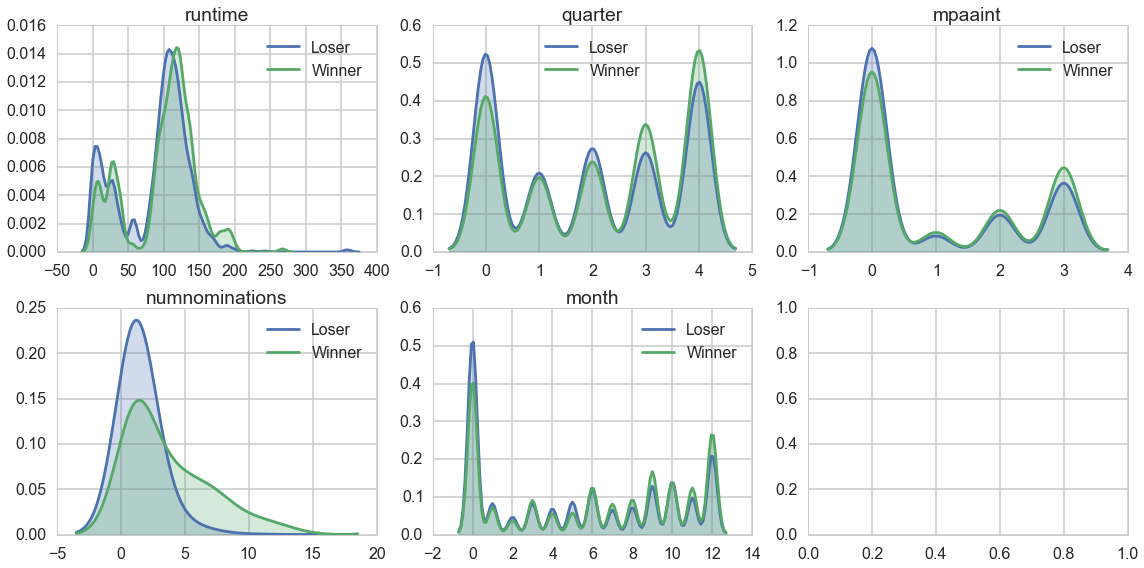

In [87]:
# Code Credit:  HW #3
dfgb=dftouse.groupby('winner')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8), 
                         tight_layout=True)
for ax, p in zip(axes.ravel(), NONINDICATORS):
    for k, v in dfgb[p]:
        if k == 0:
            label = "Loser"
        else:
            label = "Winner" 
        if p == 'runtime':
            sns.kdeplot(v, ax=ax, label = label, bw=5, shade = True)
        elif p == 'numnominations':
            sns.kdeplot(v, ax=ax, label = label, bw=1.5, shade = True)
        else:
            sns.kdeplot(v, ax=ax, label = label, bw=0.23, shade = True)
        ax.set_title(p)

####Conclusions

#####Runtime
This might be a good predictor.  We see a somewhat bimodal distribution, with peaks forming at approx 0-40 minutes and 100-120 minutes.  This can be explained by the criteria to be considered a "short film" by the Academy Awards (to be considered a short film, the runtime must not be greater than TO DO).  Both the shorter and longer movies that win tend to be slightly longer in runtime.  

#####Quarter
This also might be a good predictor.  Quarter indicates which quarter of the year the movie was released as indicated in IMDBpy (quarter=0 when NA and 1-4 otherwise)  From the plot, we see that given a movie is released in the third (Jul-Sep) and fourth (Oct-Dec) quarter, it is more likely to win.

#####MPAAint
MPAA is the parental advisory rating for a movie.  Since this is an ordinal variable, we recoded the rating as R=3, PG-13=2, PG=1, and NA=0 (note IMDBpy did not return G ratings).  This might be useful for our classifier.  We see that given a movie is rated-R, it is more likely to win.

#####Numnominations
This variable is the number of categories a movie was nominated for.  We would expect that the more a movie is nominated, the more likely it is to win in at least one of those categories, which our plot confirms

#####Month
This is variable indicates the month in which a movie was released.  Movies released September - December have a slightly higher probability of winning.  Therefore this mighte be a useful predictor in our classifier.

### Relationship between Binary Variables and Outcome

Next we look at the indicator variables.  Again, grouping by winners and losers, we should be able to see if any of the continous variables will be good predictors for Oscar winners.  A good predictor will not have overlapping distributions for winners and losers.

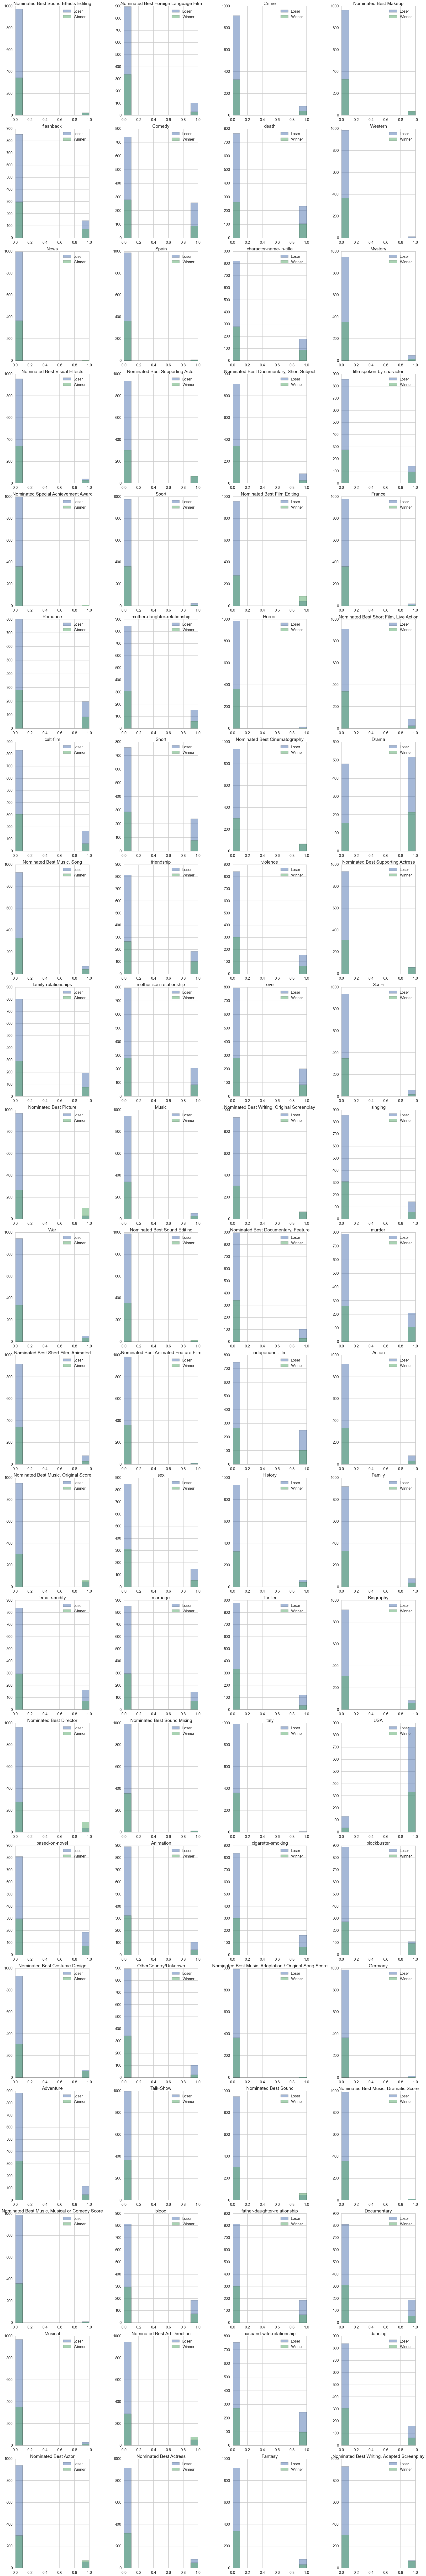

In [90]:
# Code Credit:  HW #3
fig, axes = plt.subplots(nrows=21, ncols=4, figsize=(25,150), 
                         tight_layout=True)
for ax, p in zip(axes.ravel(), INDICATORS):
    for k, v in dfgb[p]:
        if k == 0:
            label = "Loser"
        else:
            label = "Winner" 
        v.hist(ax=ax, alpha=0.5, label=label, range = [0,1])
        ax.set_title(p)
        ax.legend()

####Conclusions

#####Nominated Indicators
Nominated categories were coded using dummy variables.  Many of the "Nominated XX" indicators seem to be good predictors.  In particular a movie that is "Nominated Best Picture", "Nominated Best Director", "Nominated Best Sound", "Nominated Best Art Direction", and "Nominated Best Actor" are good indicators of a movie winning.  This makes sense because being nominated for best picture, for example, is an indication of a movie being good overall and therefore likely to win at least one Oscar.

#####Keyword Indicators
Keywords are words used to describe the movie in IMDBpy.  The top 25 keywords were coded using dummy variables.  The plots did not indicate any keywords being good predictors as there was a lot of overlap across all keywords.

####Country Indicators
The top 5 countries (plus Other Country) is coded using dummy variables.  Based off the plot, country does not seem to be a good predictor of Oscar winners.

#####Genre Indicators
We used IMDBpy to get the genre for a given movie. Movies may have more than 1 genre. Based off the plot, genre does not seem to be a good predictor of Oscar winners.

It was difficult to tell if some of these indicators would be useful in our classifier.  We continued with EDA further investigate.

In [78]:
# 1) Total number of movies nominated / won in a given year
# 2) Bar chart showing keywords by winner/losers
# 3) Bar chart showing genres
# 4) Mpaa by winner/loser
# 5) Standardize those variables

To continue EDA, we want to look at the following:

1. Countries that tend to win Oscars
2. Frequency of the top 25 keywords among Oscar winners
3. Genres that tend to win Oscars
4. The Release Date (by month) of Oscar Winners

We first get a list of the genres, countries, and keywords in our dataset

In [92]:
%%time

# Get list of unique countries, genres, keywords
# Will be used to create barcharts
genreslist = set()
countries_dict = {}
keywords_dict = {}
for _,movie in AAdf.iterrows():
    for genre in movie.genres:
        genreslist.add(genre)
    if type(movie.countrylist) == list:
        for country in movie.countrylist:
            if country in countries_dict.keys():
                countries_dict[str(country)] += 1
            else:
                countries_dict[str(country)] = 1
    if type(movie.keywords) == list:
        for keyword in movie.keywords:
            if keyword in keywords_dict.keys():
                keywords_dict[keyword] += 1
            else:
                keywords_dict[keyword] = 1

# shorten countries and keywords dictionary to only most common keywords to reduce dimensionality
numother = 0
for country in countries_dict.keys():
    if countries_dict[country] <= 10:
        numother = numother + countries_dict[country]
        del countries_dict[country]
countries_dict['OtherCountry/Unknown'] = numother
for keyword in keywords_dict.keys():
    if keywords_dict[keyword] <= 200:
        del keywords_dict[keyword]

CPU times: user 3min 11s, sys: 1.49 s, total: 3min 13s
Wall time: 3min 15s


### Countries with most winners per nominee
In terms of raw numbers, the vast majority of movies that are nominated for and win Academy Awards are from the United States. However, when you look at which countries have the most winning films per nominee (# of winners / # of nominees), the data tells a different story. Italy and Spain edge out the USA in terms of movie success.

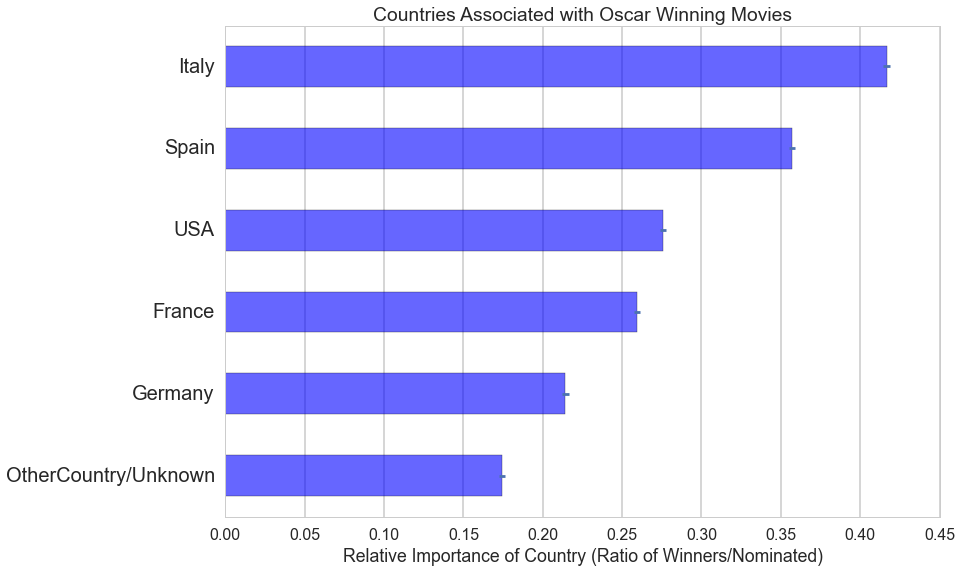

In [116]:
import operator

# Create dictionary of countries ratio (winner/total)
countries_dict_ratio = {}
for country in countries_dict.keys():
    countries_dict_ratio[country] = sum(dftouse[dftouse['winner']==1][country]) / float(countries_dict[country])
# Sort countries in order by ratio
sorted_countries = sorted(countries_dict_ratio.items(), key=operator.itemgetter(1))
    
loc1 = [0.5,1.5,2.5,3.5,4.5,5.5]
fig, ax = plt.subplots()
ax.barh(bottom=loc1,width=zip(*sorted_countries)[1],height=0.5, color='b', alpha = .6, align='center')
ax.set_ylim(0,6)
ax.set_yticks(loc1)
ax.set_yticklabels(zip(*sorted_countries)[0], size=20)
ax.set_title('Countries Associated with Oscar Winning Movies')
ax.set_xlabel("Relative Importance of Country (Ratio of Winners/Nominated)")
ax.yaxis.grid(False)
ax.legend()
plt.show()

### Most Powerful Plot Elements

Next, we take the ratio of the number of times a keyword is used to describe an Oscar winning movie compared to the overall times a keyword is used to describe an Oscar nominated movie.  We used a bar chart to visually see what keywords could help us identify winners.  Blockbuster and title-spoken-by-character are the top two, and the rest are fairly close within eachother, indicating that most of the keywords might not be helpful in building our classifier.

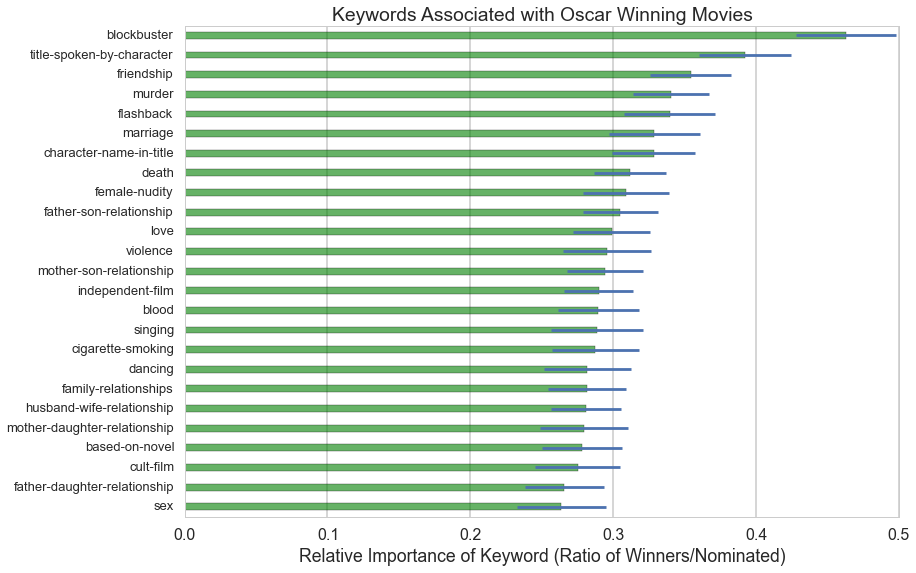

In [223]:
keywords_dict_ratio = {}
keywords_dict_ratiosd = {}
for keyword in keywords_dict.keys():
    keywords_dict_ratio[keyword] = sum(dftouse[dftouse['winner']==1][keyword]) / float(keywords_dict[keyword])
    keywords_dict_ratiosd[keyword] = np.sqrt((keywords_dict_ratio[keyword] * (1 - keywords_dict_ratio[keyword])) / keywords_dict[keyword])
# sort the movie by ratio
sorted_keywords = sorted(keywords_dict_ratio.items(), key=operator.itemgetter(1))

xerr = []
for key in sorted_keywords:
    xerr.append(keywords_dict_ratiosd[key[0]])

loc1 = range(len(sorted_keywords))
fig, ax = plt.subplots()
ax.barh(loc1,zip(*sorted_keywords)[1], 0.35, color='g', label='loser', alpha = .6, align="center", xerr = xerr)
ax.set_ylim(-0.5,24.5)
ax.set_yticks(np.arange(len(zip(*sorted_keywords)[0])))
ax.set_yticklabels(zip(*sorted_keywords)[0], size=13)
ax.set_title("Keywords Associated with Oscar Winning Movies")
ax.set_xlabel("Relative Importance of Keyword (Ratio of Winners/Nominated)")
ax.yaxis.grid(False)
plt.show()

Similar as what we did for keywords, we do for genres.  For each genre, we plot the probability of winning given it is nominated and is of a particular genre.  It appears that if a movie is of the "News" genre, it will definately win.  However this is quite misleading as there was only one "News" movie nominated which happened to win.  Following "News" is "Biography", "History", "War", "Musical" and "Music".  Therefore if movie has a genre of historical or musical types, it is likely to win, compared to the other genres.

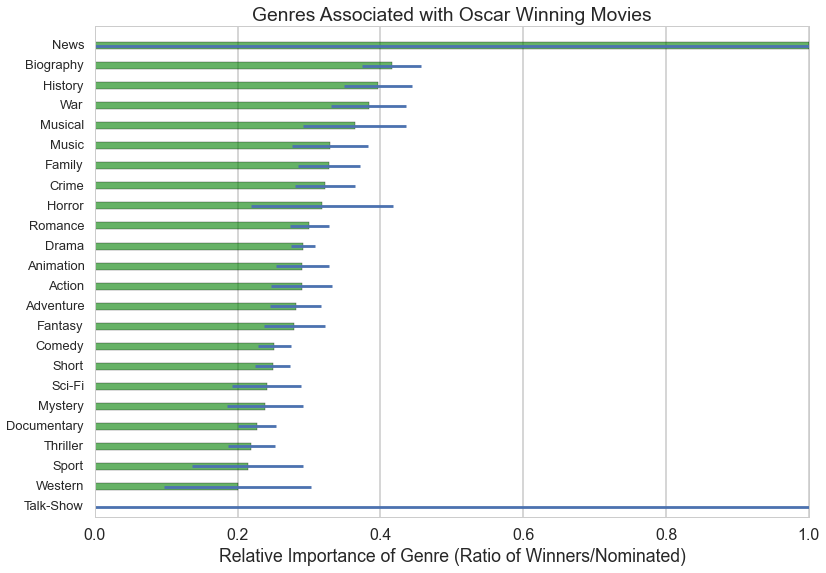

In [224]:
# Create dictionary of genre ratios (winner/total)
genres_dict_ratio = {}
genres_dict_ratiosd = {}
for genre in genreslist:
    genres_dict_ratio[genre] = sum(dftouse[dftouse['winner']==1][genre]) / float(sum(dftouse[genre]))
    genres_dict_ratiosd[genre] = np.sqrt((genres_dict_ratio[genre] * (1 - genres_dict_ratio[genre])) / float(sum(dftouse[genre])))

# sort the movie by ratio
sorted_genres = sorted(genres_dict_ratio.items(), key=operator.itemgetter(1))

xerr = []
for key in sorted_genres:
    sd = genres_dict_ratiosd[key[0]]
    if sd == 0:
        sd = 1
    xerr.append(sd)

loc1 = range(len(sorted_genres))
fig, ax = plt.subplots()
ax.barh(loc1,zip(*sorted_genres)[1], 0.35, color='g', label='loser', alpha = .6, align='center', xerr=xerr)
ax.set_xlim(0,1)
ax.set_ylim(-0.5,len(zip(*sorted_genres)[0]))
ax.set_yticks(np.arange(len(zip(*sorted_genres)[0])))
ax.set_yticklabels(zip(*sorted_genres)[0], size=13)
ax.set_title("Genres Associated with Oscar Winning Movies")
ax.set_xlabel("Relative Importance of Genre (Ratio of Winners/Nominated)")
ax.yaxis.grid(False)
plt.show()

Our earlier EDA indicated that month may be a strong predictor for Oscar winners.  We analyzed month of release further in three ways:

1. The raw numbers of the films nominated by release month
2. The raw numbers of the films which won by release month
3. The ratio of films that won to the films nominated by release month

By the raw numbers of nominated films by release month, the bar chart indicates that among the movies even considered for an Oscar, December produces the most nominated-worthy films by a long shot.  We cannot conclude that the release month is driving this phenomenon.  It is possible that the better films are released later in the year purposely.  We wondered if filmmakers purposely release their movies late in the year because the deadline to be considered for an Oscar is December 31.  This may also be a tatic for filmmakers to ensure their movies are still relevant when being considered by the Academy Awards. Another theory is that the release date is motivated by box office sales, as people typically like seeing movies around thd holiday season.

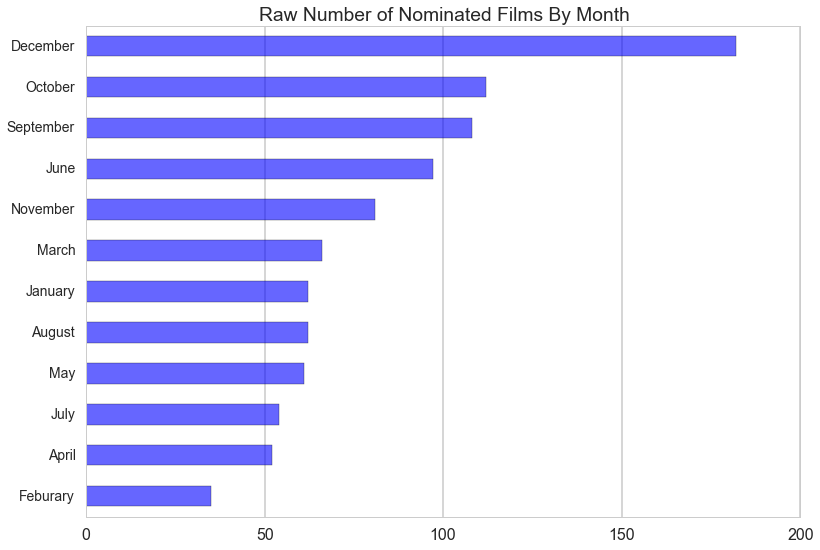

In [234]:
month_name_dict = {0:'Unknown',1:'January',2:"Feburary",3:"March",4:"April",5:"May",6:"June",7:"July",8:"August",9:"September",10:"October",11:"November",12:"December"}
month_dict = {}
for month in range(13):
    month_dict[month_name_dict[month]] = len(dftouse[(dftouse['month']==month)]) 
del month_dict['Unknown']
    
sorted_month_dict = sorted(month_dict.items(), key=operator.itemgetter(1))
    
loc1 = range(len(zip(*sorted_month_dict)[1]))
loc2 = [.35, 1.35,2.35,3.35,4.35,5.35, 6.35, 7.35, 8.35, 9.35,10.35, 11.35]
fig, ax = plt.subplots()
ax.barh(loc1, zip(*sorted_month_dict)[1], 0.5, color='b', alpha = .6, align="center")
ax.set_ylim(-0.5,11.5)
ax.set_yticks(np.arange(len(zip(*sorted_month_dict)[1])))
ax.set_yticklabels(zip(*sorted_month_dict)[0], size=14)
ax.set_title('Raw Number of Nominated Films By Month')
ax.yaxis.grid(False)
plt.show()

Seeing the raw numbers for nominees by  month made us curious of the raw numbers for winners.  December appears to be the best month to release a movie if wanting to win an Oscar.  On the other hand, it may just be that the best movies are released in December.  

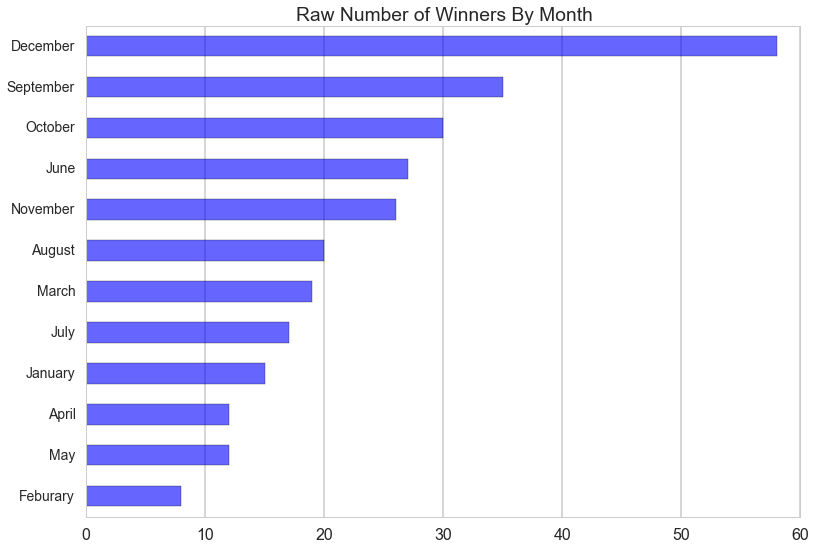

In [235]:
month_dict_winner = {}
for month in range(13):
    month_dict_winner[month_name_dict[month]] = len(dftouse[(dftouse['month']==month) & dftouse['winner']==1])
del month_dict_winner['Unknown']

sorted_month_winners = sorted(month_dict_winner.items(), key=operator.itemgetter(1))

fig, ax = plt.subplots()
ax.barh(loc1, zip(*sorted_month_winners)[1], 0.5, color='b', alpha = .6, align="center")
ax.set_ylim(-0.5,11.5)
ax.set_yticks(np.arange(len(zip(*sorted_month_winners)[1])))
ax.set_yticklabels(zip(*sorted_month_winners)[0], size=14)
ax.set_title('Raw Number of Winners By Month')
ax.yaxis.grid(False)
plt.show()

We decided it may be more telling if we took the ratio of winners released in a particular month to the nominees released in a particular month.  Then we can visualize the probability of winning, given the movie was released in a certain month. The order of months shift a bit - now September is at the top, with August, November, December, and July following right behind. 

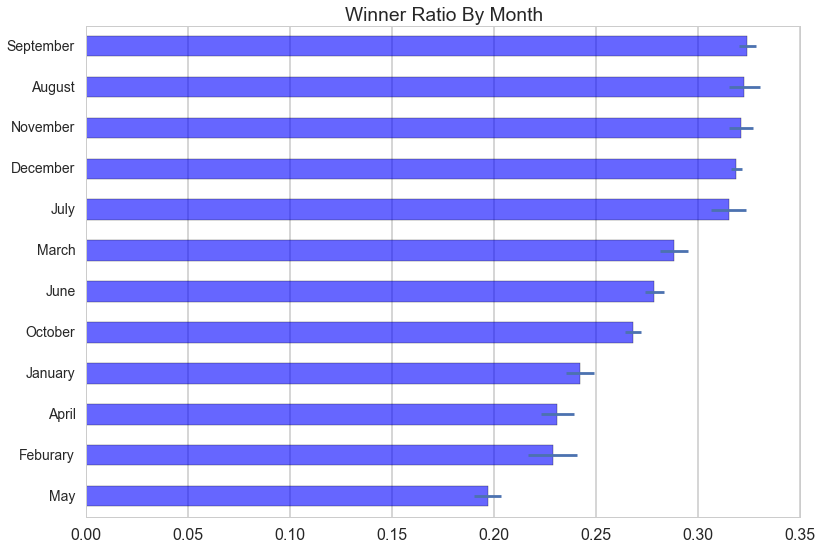

In [238]:
month_dict_ratio = {}
month_dict_ratiosd = {}
for month in range(13):
    month_dict_ratio[month_name_dict[month]] = len(dftouse[(dftouse['month']==month) & dftouse['winner']==1]) / float(sum(dftouse['month']==month))    
    month_dict_ratiosd[month_name_dict[month]] = np.sqrt((month_dict_ratio[month_name_dict[month]] * (1 - month_dict_ratio[month_name_dict[month]]))) / float(sum(dftouse['month']==month))  
del month_dict_ratio['Unknown']

sorted_month_ratio = sorted(month_dict_ratio.items(), key=operator.itemgetter(1))

xerr = []
for key in sorted_month_ratio:
    sd = month_dict_ratiosd[key[0]]
    if sd == 0:
        sd = 1
    xerr.append(sd)

fig, ax = plt.subplots()
ax.barh(loc1, zip(*sorted_month_ratio)[1], 0.5, color='b', label='winner', alpha = .6, align="center", xerr=xerr)
ax.set_ylim(-0.5,11.5)
ax.set_yticks(np.arange(len(zip(*sorted_month_ratio)[1])))
ax.set_yticklabels(zip(*sorted_month_ratio)[0], size=14)
ax.set_title('Winner Ratio By Month')
ax.yaxis.grid(False)
plt.show()

#Predicting Oscar Winners

### Splitting Data and Main Functions
We split into a test set (the movies in the last year in our dataset) and training set.  We will apply many classifiers, using our training data, to build a classifier which predicts Oscar winners.  

In [14]:
# Test Set:  will be 2006 movies
itest = dftouse.index[dftouse['year']>=2006].copy()
testdf = dftouse[dftouse['year']>=2006].copy()
# Training Set:  1981-2005 movies
itrain = dftouse.index[dftouse['year']<2005].copy()
traindf = dftouse[dftouse['year']<2005].copy()

In [15]:
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
lcols = list(INDICATORS) + list(NONINDICATORS)

First we create two functions (with the help of HW3), `cv_optimize` which is passed to our second function `do_classify`.  

The `do_classify` function takes as arguments a classifer `clf`, a dictionary of `parameters` which will be passed to GridSearchCV in order to find the best parameter, the training dataframe `indf`, the list of predictors `featurenames`, the column and value which indicates the winners `targetname` and `target1val`, either an array of if the observation is part of the training set `mask` or as an alternative a dictionary used to provide training and test sets passed in as `reusesplit`, the option to pass in a score function as `score_func`, a default of 5-fold cross validation `n_folds` and the default of 1 for `n_jobs`.

The `cv_optimize` function is used in the `do_classify` function to loop through the `parameters` given using Grid Search. It obtains the best model by the average cross-validation score and returns the best model.

Finally the `do_classify` function fits the training set and test set to the best model found in `cv_optimize`, and returns an accuracy for each.  A confusion matrix is also printed out for the predictions on teh test set in order to see how many movies were classified correctly, the number of false positives, and the number of false negatives.

In [17]:
from sklearn.grid_search import GridSearchCV
def cv_optimize(clf, parameters, X, y, n_jobs, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func, n_jobs=n_jobs)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_
    best = gs.best_estimator_
    return best

In [18]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, 
                score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask != None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, n_jobs=n_jobs, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.3f" % (training_accuracy)
    print "Accuracy on test data:     %0.3f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

Next we create a function `make_roc` with the help from HW3.  

The Roc curve will be useful in determining an appropriate threshold for our classifiers.  The function takes in the parameters the `name` of the classifer, the classifer being used `clf`, the test data `ytest` and `xtext`, `ax`, `labe` to for plotting labels, the parameter `proba` to indicate whether the classifer is probabilisitic, and `skip`.


In [19]:
# Roc curve function, taken from HW3
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

### Baseline Classifiers

Before searing for the best classifier, we want to see how well we would do if we classified all nominees as losers, and all nominiees at winners.  By classifying all movies as winners we would get 27.6% accuracy, surley we can do better than this.  On the other hand, by classifying all movies as loser we would get 72.4% accuracy!

However we realize that accuracy may not be the 

In [23]:
# Baseline: all losers =
testsize = dftouse[~mask].shape[0]
ypred_nowins = np.zeros(testsize, dtype="int")
conf_nowins = confusion_matrix(list(testdf['winner']), ypred_nowins)
print conf_nowins
print "Accuracy on test data:", (float(conf_nowins[0,0]+conf_nowins[1,1])/testsize)
#precision = (float(conf_nowins[1,1]))/(conf_nowins[1,1]+conf_nowins[0,1])
recall = (float(conf_nowins[1,1]))/(conf_nowins[1,1]+conf_nowins[1,0])
print recall

[[42  0]
 [16  0]]
Accuracy on test data: 0.724137931034
0.0


In [25]:
# Baseline: all winners = 
ypred_allwins = np.ones(testsize, dtype="int")
conf_allwins = confusion_matrix(list(testdf['winner']), ypred_allwins)
print conf_allwins
print "Accuracy on test data:", (float(conf_allwins[0,0]+conf_allwins[1,1])/testsize)
recall = (float(conf_allwins[1,1]))/(conf_allwins[1,1]+conf_allwins[1,0])
print recall

[[ 0 42]
 [ 0 16]]
Accuracy on test data: 0.275862068966
1.0


### Logistic Regression Techniques

#### Logistic Ridge Regression

In [16]:
from sklearn.linear_model import LogisticRegression

clflog_ridge, Xtrain, ytrain, Xtest, ytest = do_classify(LogisticRegression(penalty="l2"),
                                                   {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, 
                                                   indf=dftouse, featurenames=lcols, targetname='winner', 
                                                   target1val=1, mask=mask)

using mask
BEST {'C': 1.0} 0.795558958652
############# based on standard predict ################
Accuracy on training data: 0.811
Accuracy on test data:     0.810
[[41  1]
 [10  6]]
########################################################


C:\Users\Steven\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [17]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

#### Logistic Regression with LASSO

In [18]:
clflog_lasso, _, _, _, _ = do_classify(LogisticRegression(penalty="l1"),
                                       {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, 
                                       indf=dftouse, featurenames=lcols, targetname='winner', 
                                       target1val=1, reuse_split=reuse_split)

using reuse split
BEST {'C': 0.1} 0.799387442573
############# based on standard predict ################
Accuracy on training data: 0.810
Accuracy on test data:     0.828
[[42  0]
 [10  6]]
########################################################


#### Elastic Net Regularized Logistic Regression

In [19]:
from sklearn.linear_model import SGDClassifier

clflog_elastic, _, _, _, _ = do_classify(SGDClassifier(loss="log",penalty="elasticnet"), 
                                         {"alpha": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                                          "l1_ratio": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
                                         indf=dftouse, featurenames=lcols, targetname='winner', 
                                         target1val=1, reuse_split=reuse_split)

using reuse split
BEST {'alpha': 0.1, 'l1_ratio': 0.2} 0.763399693721
############# based on standard predict ################
Accuracy on training data: 0.704
Accuracy on test data:     0.707
[[32 10]
 [ 7  9]]
########################################################


In [20]:
import sklearn.metrics as metrics

def t_repredict_accuracy(clf,t, xtest, ytest):
    probs=clf.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return metrics.accuracy_score(ytest, ypred)

In [22]:
for percent in np.arange(0.30,0.60,0.05):
    print "RidgeReg Accuracy at",percent,"%: ",t_repredict_accuracy(clflog_ridge,percent,Xtest,ytest)
print ""
for percent in np.arange(0.30,0.60,0.05):
    print "LassoReg Accuracy at",percent,"%: ",t_repredict_accuracy(clflog_lasso,percent,Xtest,ytest)
print ""
for percent in np.arange(0.30,0.60,0.05):
    print "ElasticReg Accuracy at",percent,"%: ",t_repredict_accuracy(clflog_elastic,percent,Xtest,ytest)

RidgeReg Accuracy at 0.3 %:  0.810344827586
RidgeReg Accuracy at 0.35 %:  0.827586206897
RidgeReg Accuracy at 0.4 %:  0.810344827586
RidgeReg Accuracy at 0.45 %:  0.810344827586
RidgeReg Accuracy at 0.5 %:  0.810344827586
RidgeReg Accuracy at 0.55 %:  0.827586206897

LassoReg Accuracy at 0.3 %:  0.862068965517
LassoReg Accuracy at 0.35 %:  0.844827586207
LassoReg Accuracy at 0.4 %:  0.827586206897
LassoReg Accuracy at 0.45 %:  0.844827586207
LassoReg Accuracy at 0.5 %:  0.827586206897
LassoReg Accuracy at 0.55 %:  0.810344827586

ElasticReg Accuracy at 0.3 %:  0.275862068966
ElasticReg Accuracy at 0.35 %:  0.293103448276
ElasticReg Accuracy at 0.4 %:  0.396551724138
ElasticReg Accuracy at 0.45 %:  0.603448275862
ElasticReg Accuracy at 0.5 %:  0.706896551724
ElasticReg Accuracy at 0.55 %:  0.706896551724


## SVM Techniques

#### Balance Features

In [23]:
jtrain=np.arange(0, ytrain.shape[0])
n_pos=len(jtrain[ytrain==1])
n_neg=len(jtrain[ytrain==0])
print n_pos, n_neg

351 955


In [24]:
ineg = np.random.choice(jtrain[ytrain==0], n_pos, replace=False)
alli=np.concatenate((jtrain[ytrain==1], ineg))

Xtrain_new = Xtrain[alli]
ytrain_new = ytrain[alli]
Xtrain_new.shape, ytrain_new.shape

((702L, 90L), (702L,))

In [25]:
reuse_split_new=dict(Xtrain=Xtrain_new, Xtest=Xtest, ytrain=ytrain_new, ytest=ytest)

#### SVM (Linear Kernel) - All Features Balanced

In [26]:
from sklearn.svm import LinearSVC

clf_linsvm, _, _, _, _ = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, 
                                       indf=dftouse, featurenames=lcols, targetname='winner', 
                                       target1val=1, reuse_split=reuse_split)

using reuse split
BEST {'C': 0.01} 0.791730474732
############# based on standard predict ################
Accuracy on training data: 0.799
Accuracy on test data:     0.810
[[42  0]
 [11  5]]
########################################################


#### SVM (RBF Kernel) - All Features Balanced

In [27]:
from sklearn.svm import SVC

clf_rbfsvm, _, _, _, _ = do_classify(SVC(kernel="rbf"),
                                       {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, 
                                       indf=dftouse, featurenames=lcols, targetname='winner', 
                                       target1val=1, reuse_split=reuse_split)

using reuse split
BEST {'C': 1.0} 0.786370597243
############# based on standard predict ################
Accuracy on training data: 0.815
Accuracy on test data:     0.793
[[41  1]
 [11  5]]
########################################################


##### Random Forest Classifier

Because the RandomForest Classifier can't take categorical variables as inputs.  Therefore we have to deal with the categorical variables in some way.

For categorical variables that are considered ordinal (mpaa), we can just convert them to ints.
For categorical varaibles that are not ordinal (keywords), we will use sparse matrcies.

In [1]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf_randomforest, _, _, _, _ = do_classify(RandomForestClassifier(n_estimators=10, random_state=0),
                                       {"max_depth": [5,10,15,20,25],"min_samples_split":[5,10,15,20,25]}, 
                                       indf=dftouse, featurenames=lcols, targetname='winner', 
                                       target1val=1, reuse_split=reuse_split, n_jobs=2)

NameError: name 'do_classify' is not defined

### Model Setup

### Cross Validation

#Exploratory Data Analysis

#Final Analysis

#Presentation